# Overview
**Assignment 2** focuses on the training on a Neural Machine Translation (NMT) system for English-Irish translation where English is the source language and Irish is the target language. 

**Grading Policy** 
Assignment 2 is graded and will be worth 25% of your overall grade. This assignment is worth a total of 50 points distributed over the tasks below.  Please note that this is an individual assignment and you must not work with other students to complete this assessment. Any copying from other students, from student exercises from previous years, and any internet resources will not be tolerated. Plagiarised assignments will receive zero marks and the students who commit this act will be reported. Feel free to reach out to the TAs and instructors if you have any questions.

## Task 1 - Data Collection and Preprocessing (10 points)
## Task 1a. Data Loading (5 pts)
Dataset: https://www.dropbox.com/s/zkgclwc9hrx7y93/DGT-en-ga.txt.zip?dl=0 
*  Download a English-Irish dataset and decompress it. The `DGT.en-ga.en` file contains a list english sentences and `DGT.en-ga.ga` contains the paralell Irish sentences. Read both files into the Jupyter environment and load them into a pandas dataframe. 
* Randomly sample 12,000 rows.
* Split the sampled data into train (10k), development (1k) and test set (1k)

In [1]:
# Your Code Here

import pandas as pd

# read the files by line
with open("DGT-en-ga.txt/DGT.en-ga.en") as f:
    english = f.read().splitlines()

with open("DGT-en-ga.txt/DGT.en-ga.ga") as f:
    irish = f.read().splitlines()
    
assert len(english) == len(irish)

# create a df contains english lines with coresponding french lines
data = pd.DataFrame({
            'source': english,
            'target': irish
        })
data["len"] = data["target"].apply(lambda x: len(x.split(" ")))

In [2]:
# Randomly sample 12,000 rows.
sample = data.sample(12000, random_state=2023)

In [3]:
# Split the sampled data into train (10k), development (1k) and test set (1k)
from sklearn.model_selection import train_test_split

train, test = train_test_split(sample, test_size=0.0833, random_state=2013)
train, val = train_test_split(train, test_size=0.0909, random_state=2013)

train["split"] = "train"
val["split"] = "split"
test["split"] = "test"

dataset = pd.concat([train, val, test])

print(f"Dataset => Train {len(train)} | Val {len(val)} | Test {len(test)}")

dataset.head(5)

Dataset => Train 10000 | Val 1000 | Test 1000


,source,target,len,split
34872,The National Committee shall be responsible fo...,Beidh an Coiste Náisiúnta freagrach as roghnú ...,10,train
22502,"For the purposes of this Regulation, the defin...","Chun críche an Rialacháin seo, beidh feidhm ag...",50,train
103092,Action to be taken following official controls,"athléimneacht,",1,train
119903,The Member States and in particular the compet...,Féadfaidh an Coimisiún freisin a iarraidh ar a...,36,train
32092,A delegated act adopted pursuant to Article 11...,Ní thiocfaidh gníomh tarmligthe a ghlactar de ...,83,train


## Task 1b. Preprocessing (5 pts)
* Add '<bof\>' to denote beginning of sentence and '<eos\>' to denote the end of the sentence to each target line.
* Perform the following pre-processing steps:
  * Lowercase the text
  * Remove all punctuation
  * tokenize the text 
*  Build seperate vocabularies for each language. 
  * Assign each unique word an id value 
*Print statistics on the selected dataset:
  * Number of samples
  * Number of unique source language tokens
  * Number of unique target language tokens
  * Max sequence length of source language
  * Max sequence length of target language



In [4]:
# Your code here
from nltk.tokenize import word_tokenize
from typing import List
import re

class Language:
    
    def __init__(self, language: str):
        self.language = language, # name of the language
        self.word2index = {"PAD": 0, "SOS": 1, "EOS": 2} # map each word in vocab to id
        self.index2word = {0: "PAD", 1: "SOS", 2: "EOS"} # reverse map of id to word in vocab
        self.word2count = {} # count of each word in vocab
        self.n_words = len(self.index2word) # number of words in vocab
        
    def addSentence(self, sentence: str):
        """
        Given a sentence, 
            lowercase the sentence, 
            remove all punctuation and 
            tokenize it.
        For each word in tokenized list call the addWord method
        """
        
        text = sentence.lower() # lowercase the sentence
        clean_text = re.sub(r'[^\w\s]', '', text).strip() # remove all punctuation
        for word in word_tokenize(clean_text): # tokenize the sentence
            self.addWord(word)
            
    def addWord(self, word: str):
        """
        For each input word, check if it exists in the word2index. 
        Update.
        """
        
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
            
        else:
            self.word2count[word] += 1
            
    def encodeSentence(self, sentence: str) -> List[int]:
        """
        Given a sentence, 
            lowercase it, 
            remove all punctuation, 
            add "SOS" and "EOS", and 
            tokenize it
        Return a list of word ids.
        """
        
        text = sentence.lower()
        clean_text = re.sub(r'[^\w\s]', '', text).strip()
        
        # Add '<bof>' to denote beginning of sentence and '<eos>' to denote the end of the sentence to each target line.
        clean_text = "SOS " + clean_text + " EOS" 
        
        return [self.word2index[word] for word in word_tokenize(clean_text) if word in self.word2index]
    
    def decodeIds(self, ids: list) -> List[str]:
        """
        Given a list of word ids, look for the ids in the index2word and return a string representing the decoded sentence.
        """
        
        return " ".join([self.index2word[tok] for tok in ids])

In [5]:
# Build seperate vocabularies for each language.
english = Language("english")
irish = Language("irish")

for _, row in dataset.iterrows():
    english.addSentence(row["source"])
    irish.addSentence(row["target"])

In [6]:
# print

print(f"Number of samples: {len(sample)}")
print(f"Number of unique source language tokens: {english.n_words}")
print(f"Number of unique target language tokens: {irish.n_words}")
print(f"Max sequence length of source language: {len(max(dataset['source']))}")
print(f"Max sequence length of target language: {len(max(dataset['target']))}")

Number of samples: 12000
Number of unique source language tokens: 11828
Number of unique target language tokens: 16240
Max sequence length of source language: 152
Max sequence length of target language: 43


## Task 2. Model Implementation and Training (30 pts)



## Task 2a. Encoder-Decoder Model Implementation (10 pts)
Implement an Encoder-Decoder model in Pytorch with the following components
* A single layer RNN based encoder. 
* A single layer RNN based decoder
* A Encoder-Decoder model based on the above components that support sequence-to-sequence modelling. For the encoder/decoder you can use RNN, LSTMs or GRU. Use a hidden dimension of 256 or less depending on your compute constraints. 

In [7]:
# Your code here
import torch
import torch.nn as nn
import torch.nn.functional as F

# code reference: https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb

In [8]:
# A single layer RNN based encoder.
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, (hidden, cell) = self.rnn(embedded)
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell

In [9]:
# A single layer RNN based decoder
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
                
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.fc_out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell

In [10]:
# A Encoder-Decoder model based on the above components that support sequence-to-sequence modelling. For the encoder/decoder I use LSTMs
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs

In [11]:
INPUT_DIM = english.n_words
OUTPUT_DIM = irish.n_words
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 128
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

#device = "mps" if torch.backends.mps.is_available() else "cpu"
device = "cpu"

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = EncoderDecoder(enc, dec, device).to(device)

In [12]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

EncoderDecoder(
  (encoder): Encoder(
    (embedding): Embedding(11828, 256)
    (rnn): LSTM(256, 128, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(16240, 256)
    (rnn): LSTM(256, 128, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=128, out_features=16240, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

## Task 2b. Training (10 pts)
Implement the code to train the Encoder-Decoder model on the Irish-English data. You will write code for the following:
* Training, validation and test dataloaders 
* A training loop which trains the model for 5 epoch. Evaluate the loop at the end of each Epoch. Print out the train perplexity and validation perplexity after each epoch.

In [13]:
# Your Code Here
import torch 
from tensorflow.keras.utils import pad_sequences
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset

In [14]:
def encode_features(
    df: pd.DataFrame,
    english: Language,
    irish: Language,
    pad_token: int = 0,
    max_seq_length = 10
):
    
    source = []
    target = []
    
    for _, row in df.iterrows():
        source.append(english.encodeSentence(row["source"]))
        target.append(irish.encodeSentence(row["target"]))
        
    source = pad_sequences(
        source,
        maxlen = max_seq_length,
        padding = "post",
        truncating = "post",
        value = pad_token
    )
    
    target = pad_sequences(
        target,
        maxlen = max_seq_length,
        padding = "post",
        truncating = "post",
        value = pad_token
    )
    
    return source, target

In [15]:
train_source, train_target = encode_features(train, english, irish)
val_source, val_target = encode_features(val, english, irish)
test_source, test_target = encode_features(test, english, irish)

print(f"Shapes of train source {train_source.shape}, and target {train_target.shape}")
print(f"Shapes of val source {val_source.shape}, and target {val_target.shape}")
print(f"Shapes of test source {test_source.shape}, and target {test_target.shape}")

Shapes of train source (10000, 10), and target (10000, 10)
Shapes of val source (1000, 10), and target (1000, 10)
Shapes of test source (1000, 10), and target (1000, 10)


In [16]:
# Training, validation and test dataloaders

train_dl = DataLoader(
    TensorDataset(
        torch.LongTensor(train_source),
        torch.LongTensor(train_target)
    ),
    shuffle = True,
    batch_size = 32
)

val_dl = DataLoader(
    TensorDataset(
        torch.LongTensor(val_source),
        torch.LongTensor(val_target)
    ),
    shuffle = True,
    batch_size = 32
)

test_dl = DataLoader(
    TensorDataset(
        torch.LongTensor(test_source),
        torch.LongTensor(test_target)
    ),
    shuffle = True,
    batch_size = 32
)

In [17]:
for batch in train_dl:
    print( batch[0].shape, batch[1].shape )
    break

torch.Size([32, 10]) torch.Size([32, 10])


In [18]:
from tqdm import tqdm
import numpy as np 
import random

optimizer = torch.optim.Adam(model.parameters())

model.to(device)

EPOCHS = 5
best_val_loss = float('inf')

for epoch in range(EPOCHS):

    model.train()
    epoch_loss = 0
    for batch in train_dl:

        src = batch[0].transpose(1, 0).to(device)
        trg = batch[1].transpose(1, 0).to(device)

        optimizer.zero_grad()

        output = model(src, trg)

        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim).to(device)
        trg = trg[1:].reshape(-1)
     
        loss = F.cross_entropy(output, trg)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        epoch_loss += loss.item()

    train_loss = round(epoch_loss / len(train_dl), 3)
  
    eval_loss = 0
    model.eval()
    for batch in val_dl:
        src = batch[0].transpose(1, 0).to(device)
        trg = batch[1].transpose(1, 0).to(device)

        with torch.no_grad():
            output = model(src, trg)

            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim).to(device)
            trg = trg[1:].reshape(-1)

            loss = F.cross_entropy(output, trg)

            eval_loss += loss.item()
  
    val_loss = round(eval_loss / len(val_dl), 3)
    print(f"Epoch {epoch} | train loss {train_loss} | train ppl {np.exp(train_loss)} | val ppl {np.exp(val_loss)}")


    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best-model.pt')  

Epoch 0 | train loss 6.405 | train ppl 604.8617986785431 | val ppl 399.81422431092756
Epoch 1 | train loss 5.755 | train ppl 315.7655475242052 | val ppl 368.706155409357
Epoch 2 | train loss 5.606 | train ppl 272.0538432960144 | val ppl 337.3091942259041
Epoch 3 | train loss 5.485 | train ppl 241.04894399802745 | val ppl 325.70758489800846
Epoch 4 | train loss 5.364 | train ppl 213.5775503062535 | val ppl 301.87106828279025


# Task 2c. Evaluation on the Test Set (10 pts)
Use the trained model to translate the text from the source language into the target language on the test set. Evaluate the performance of the model on the test set using the BLEU metric and print out the average the BLEU score.

In [19]:
# Your code here

In [20]:
def translate_sentence(
    text: str,
    model: EncoderDecoder,
    english: Language,
    irish: Language,
    device: str,
    max_len: int = 10
) -> str:
    
    # encode english sentence and convert to tensor
    input_ids = english.encodeSentence(text)
    input_tensor = torch.LongTensor(input_ids).unsqueeze(1).to(device)
    
    # Get encoder hidden states
    with torch.no_grad():
        hidden, cell = model.encoder(input_tensor)
        
    # build target holder list
    trg_indexes = [irish.word2index["SOS"]]
    
    # loop over sequence length of target sentence
    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
        
        # decide the encoder outputs with respect to current target word
        with torch.no_grad():
            prediction, hidden, cell = model.decoder(trg_tensor, hidden, cell)
            
        # retrieve most likely word over target distribution
        pred_token = torch.argmax(prediction).item()
        trg_indexes.append(pred_token)
        
        if pred_token == irish.word2index["EOS"]:
            break
            
    return "".join(irish.decodeIds(trg_indexes))

In [31]:
def bleu_score(reference_sentence, candidate_sentence):
    return len([word for word in candidate_sentence if word in reference_sentence]) / len(reference_sentence)

In [35]:
avg_bleu1_score = 0.0
bleus = []

for _, row in test.iterrows():
    source_sentence = row["source"]
    reference_sentence = row["target"]
    candidate_sentence = translate_sentence(text=source_sentence,
                                            model=model,
                                            english = english,
                                            irish=irish,
                                            device=device
                                           )
    bleu1_score = bleu_score(reference_sentence=reference_sentence, 
                            candidate_sentence=candidate_sentence)
    
    bleus.append(bleu1_score)
    
    # print(f"source_sentence: {source_sentence}\nreference_sentence: {reference_sentence}\ncandidate_sentence: {candidate_sentence}\nBLEU score: {bleu1_score}")

The average the BLEU-1 score: 0.31


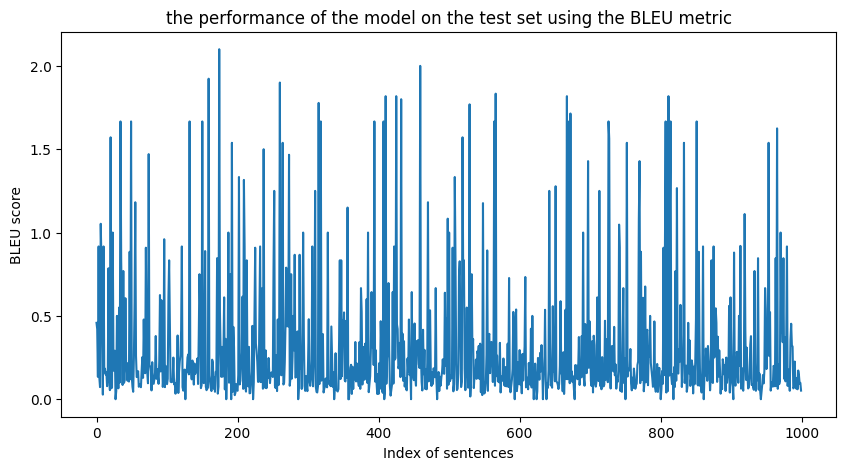

In [39]:
# plot and evaluate the performance of the model on the test set using the BLEU metric
import matplotlib.pyplot as plt

#plt.plot(bleus)
fig = plt.figure(figsize=(10, 5))
plt.xlabel("Index of sentences")
plt.ylabel("BLEU score")
plt.title("the performance of the model on the test set using the BLEU metric")
plt.plot(bleus)
plt.show()

In [40]:
avg_bleu1_score = sum(bleus) / len(test)

print(f"The average the BLEU-1 score: {avg_bleu1_score:.3}")

The average the BLEU-1 score: 0.31


## Task 3. Improving NMT using Attention (10 pts) 
Extend the Encoder-Decoder model from Task 2 with the attention mechanism. Retrain the model and evaluate on test set. Print the updated average BLEU score on the test set. In a few sentences explains which model is the best for translation. 

In [41]:
# extend encoder with GRU
# code reference: lab materials

class EncoderGRU(nn.Module):
    def __init__(
        self, 
        input_vocab_size,  # size of source vocabulary  
        hidden_dim,        # hidden dimension of embeddings
        encoder_hid_dim,   # gru hidden dim
        decoder_hid_dim,   # decoder hidden dim 
        dropout_prob = .5
      ):
      
        super().__init__()
        self.embedding = nn.Embedding(input_vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, encoder_hid_dim, bidirectional = True)
        self.fc = nn.Linear(encoder_hid_dim * 2, decoder_hid_dim)
        self.dropout = nn.Dropout(dropout_prob)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        outputs, hidden = self.rnn(embedded)
                
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards GRU
        #hidden [-1, :, : ] is the last of the backwards GRU
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))        
        return outputs, hidden

In [42]:
class Attention(nn.Module):
    def __init__(
        self, 
        enc_hid_dim,      # Encoder hidden dimension
        dec_hid_dim       # Decoder hidden dimension 
      ):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]
        attention = self.v(energy).squeeze(2)
        
        #attention output: [batch size, src len]
        return F.softmax(attention, dim=1)

In [43]:
# extend decoder with GRU
class DecoderGRU(nn.Module):
    def __init__(
        self, 
        target_vocab_size,    # Size of target vocab 
        hidden_dim,           # hidden size of embedding  
        enc_hid_dim, 
        dec_hid_dim, 
        dropout
      ):
        super().__init__()

        self.output_dim = target_vocab_size
        self.attention = Attention(enc_hid_dim, dec_hid_dim)
        
        self.embedding = nn.Embedding(target_vocab_size, hidden_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + hidden_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear(
            (enc_hid_dim * 2) + dec_hid_dim + hidden_dim, 
            target_vocab_size
          )
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        input = input.unsqueeze(0)  # [1, batch size]
        
        embedded = self.dropout(self.embedding(input))  # [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs)     # [batch size, src len]
        a = a.unsqueeze(1)                              # [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2) # [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)           # [batch size, 1, enc hid dim * 2]
        weighted = weighted.permute(1, 0, 2)               # [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2) # [1, batch size, (enc hid dim * 2) + emb dim]

        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]    
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1)) # [batch size, output dim]
        return prediction, hidden.squeeze(0)

In [44]:
import random 
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time     
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):     
            #insert input token embedding, previous hidden state and all encoder hidden states
            #receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        return outputs

In [45]:
INPUT_DIM = english.n_words
OUTPUT_DIM = irish.n_words
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 128
DEC_HID_DIM = 128
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = EncoderGRU(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = DecoderGRU(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT)

seq2seq_model = Seq2Seq(enc, dec)

def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
seq2seq_model.apply(init_weights)

Seq2Seq(
  (encoder): EncoderGRU(
    (embedding): Embedding(11828, 256)
    (rnn): GRU(256, 128, bidirectional=True)
    (fc): Linear(in_features=256, out_features=128, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): DecoderGRU(
    (attention): Attention(
      (attn): Linear(in_features=384, out_features=128, bias=True)
      (v): Linear(in_features=128, out_features=1, bias=False)
    )
    (embedding): Embedding(16240, 256)
    (rnn): GRU(512, 128)
    (fc_out): Linear(in_features=640, out_features=16240, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [46]:
# training and evaluation

optimizer = torch.optim.Adam(seq2seq_model.parameters())

device = "mps" if torch.backends.mps.is_available() else "cpu"

seq2seq_model.to(device)

EPOCHS = 5
best_val_loss = float('inf')

for epoch in range(EPOCHS):

    seq2seq_model.train()
    epoch_loss = 0
    for batch in train_dl:

        src = batch[0].transpose(1, 0).to(device)
        trg = batch[1].transpose(1, 0).to(device)

        optimizer.zero_grad()

        output = seq2seq_model(src, trg)

        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim).to(device)
        trg = trg[1:].reshape(-1)

        loss = F.cross_entropy(output, trg)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(seq2seq_model.parameters(), 1)
        optimizer.step()
        epoch_loss += loss.item()

    train_loss = round(epoch_loss / len(train_dl), 3)
  
    eval_loss = 0
    seq2seq_model.eval()
    for batch in val_dl:
        src = batch[0].transpose(1, 0).to(device)
        trg = batch[1].transpose(1, 0).to(device)

        with torch.no_grad():
            output = seq2seq_model(src, trg)

            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim).to(device)
            trg = trg[1:].reshape(-1)

            loss = F.cross_entropy(output, trg)

            eval_loss += loss.item()
  
    val_loss = round(eval_loss / len(val_dl), 3)
    print(f"Epoch {epoch} | train loss {train_loss} | train ppl {np.exp(train_loss)} | val ppl {np.exp(val_loss)}")


    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(seq2seq_model.state_dict(), 'best-model.pt')  

/opt/homebrew/Caskroom/miniconda/base/envs/research/lib/python3.9/site-packages/torch/autograd/__init__.py:204: UserWarning: 1MPS: no support for int64 reduction ops, casting it to int32 (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/ReduceOps.mm:143.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0 | train loss 9.695 | train ppl 16236.222792589699 | val ppl 16236.222792589699
Epoch 1 | train loss 9.695 | train ppl 16236.222792589699 | val ppl 16236.222792589699
Epoch 2 | train loss 9.695 | train ppl 16236.222792589699 | val ppl 16236.222792589699
Epoch 3 | train loss 9.695 | train ppl 16236.222792589699 | val ppl 16236.222792589699
Epoch 4 | train loss 9.695 | train ppl 16236.222792589699 | val ppl 16236.222792589699


In [56]:
def translate_sentence(
    text: str, 
    model: EncoderDecoder, 
    english: Language,
    irish: Language,
    device: str,
    max_len: int = 10,
  ) -> str:

    # Encode english sentence and convert to tensor
    input_ids = english.encodeSentence(text)
    input_tensor = torch.LongTensor(input_ids).unsqueeze(1).to(device)

    # Get encooder hidden states
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(input_tensor)

    # Build target holder list
    trg_indexes = [irish.word2index["SOS"]]

    # Loop over sequence length of target sentence
    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)

        # Decode the encoder outputs with respect to current target word
        with torch.no_grad():
            output, hidden = model.decoder(trg_tensor, hidden, encoder_outputs)

        # Retrieve most likely word over target distribution
        pred_token = torch.argmax(output).item()
        trg_indexes.append(pred_token)

        if pred_token == irish.word2index["EOS"]:
            break

    return "".join(irish.decodeIds(trg_indexes))

In [57]:
avg_bleu1_score = 0.0
bleus = []

for _, row in test.iterrows():
    source_sentence = row["source"]
    reference_sentence = row["target"]
    candidate_sentence = translate_sentence(text=source_sentence,
                                            model=seq2seq_model,
                                            english = english,
                                            irish=irish,
                                            device=device
                                           )
    bleu1_score = bleu_score(reference_sentence=reference_sentence, 
                            candidate_sentence=candidate_sentence)
    
    bleus.append(bleu1_score)
    
    # print(f"source_sentence: {source_sentence}\nreference_sentence: {reference_sentence}\ncandidate_sentence: {candidate_sentence}\nBLEU score: {bleu1_score}")

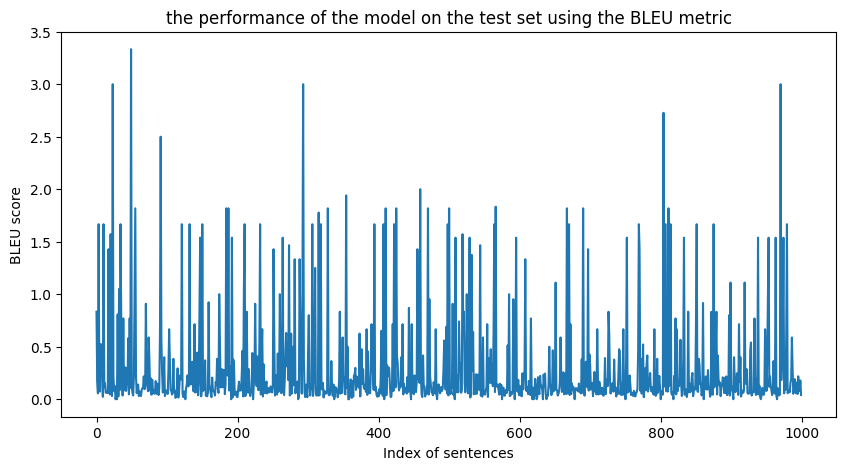

In [58]:
# plot and evaluate the performance of the model on the test set using the BLEU metric
import matplotlib.pyplot as plt

#plt.plot(bleus)
fig = plt.figure(figsize=(10, 5))
plt.xlabel("Index of sentences")
plt.ylabel("BLEU score")
plt.title("the performance of the model on the test set using the BLEU metric")
plt.plot(bleus)
plt.show()

In [62]:
avg_bleu1_score = sum(bleus) / len(test)

print(f"The average BLEU-1 score: {avg_bleu1_score:.3}")

The average BLEU-1 score: 0.295


**Comparison of the two models implemented above based on this translation task.**

EncoderDecoder model without attention proved with better performance than Sequence2Sequence model with attention mechanism. The range of the BLEU-1 score of EncoderDecoder model is between 0.0 and 2.0, whereas the range of the BLEU-1 score of Sequence2Sequence model is between 0.0 and 3.5. In addition, the average BLEU-1 score of EncoderDecoder model is 0.31 which is better than the average BLEU score of the Sequence2Sequence model which is 0.295. Therefore, EncoderDecoder model performs better than Sequence2Sequence model does in this case.